In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt


In [20]:

# -----------------------
# 1. Load processed dataset
# -----------------------
df_agg = pd.read_csv("../data/features/features_agg.csv", parse_dates=["DATETIME"])
df_agg.set_index("DATETIME", inplace=True)

df0 = pd.read_csv("../data/features/features_original.csv", parse_dates=["DATETIME"])
df0.set_index("DATETIME", inplace=True)


In [21]:
df_agg.index

DatetimeIndex(['2025-08-13 03:00:00', '2025-08-13 03:30:00',
               '2025-08-13 04:00:00', '2025-08-13 04:30:00',
               '2025-08-13 05:00:00', '2025-08-13 05:30:00',
               '2025-08-13 06:00:00', '2025-08-13 08:30:00',
               '2025-08-13 09:00:00', '2025-08-13 09:30:00',
               '2025-08-13 10:00:00', '2025-08-13 10:30:00',
               '2025-08-13 11:00:00', '2025-08-13 11:30:00',
               '2025-08-13 12:00:00', '2025-08-13 18:00:00',
               '2025-08-13 18:30:00', '2025-08-13 19:00:00',
               '2025-08-13 19:30:00', '2025-08-13 20:00:00',
               '2025-08-13 20:30:00', '2025-08-13 21:00:00',
               '2025-08-13 21:30:00', '2025-08-13 22:00:00',
               '2025-08-13 22:30:00', '2025-08-13 23:00:00',
               '2025-08-13 23:30:00', '2025-08-14 00:00:00',
               '2025-08-14 00:30:00', '2025-08-14 01:00:00',
               '2025-08-14 01:30:00', '2025-08-14 02:00:00',
               '2025-08-

In [22]:


target = "LOCAL_PRICE_ADJUSTMENT"



features = [col for col in df_agg.columns if col not in ["DATETIME", target]]
X_agg = df_agg[features]
y_agg = df_agg[target]

features = [col for col in df0.columns if col not in ["DATETIME", target]]
X0 = df0[features]
y0 = df0[target]    

In [23]:
X_agg.head()

,LOCALLY_CONSTRAINED,hour,day_of_week,month,is_weekend,is_weekday,lag_1,lag_2,lag_3,lag_4,...,lag_12,lag_24,price_roll_mean_3,price_roll_std_3,price_roll_mean_6,price_roll_std_6,price_roll_mean_12,price_roll_std_12,price_roll_mean_24,price_roll_std_24
DATETIME,,,,,,,,,,,,,,,,,,,,,
2025-08-13 03:00:00,2.0,3,2,8,0,1,44.699032,36.254516,33.236452,74.132258,...,6.992258,-107.038070,46.131505,10.665618,46.967903,15.971173,33.415726,19.114956,22.939646,23.324532
2025-08-13 03:30:00,2.0,3,2,8,0,1,57.440968,44.699032,36.254516,33.236452,...,36.677742,-8.985714,56.729032,11.690302,52.301720,16.909756,36.029839,21.586791,26.149346,24.029853
2025-08-13 04:00:00,2.0,4,2,8,0,1,68.047097,57.440968,44.699032,36.254516,...,20.515806,-11.657115,63.421505,5.431335,50.742419,14.792953,39.718226,22.458683,29.334078,23.865823
2025-08-13 04:30:00,2.0,4,2,8,0,1,64.776452,68.047097,57.440968,44.699032,...,18.277097,-26.312188,70.533548,7.324025,58.332527,15.671522,44.759892,23.949131,33.712799,22.830406
2025-08-13 05:00:00,2.0,5,2,8,0,1,78.777097,64.776452,68.047097,57.440968,...,20.542581,21.883636,70.093118,7.583443,63.411075,11.456367,48.608495,23.408336,35.581222,23.640768


In [24]:
X_agg.count()

LOCALLY_CONSTRAINED    36
hour                   36
day_of_week            36
month                  36
is_weekend             36
is_weekday             36
lag_1                  36
lag_2                  36
lag_3                  36
lag_4                  36
lag_5                  36
lag_6                  36
lag_12                 36
lag_24                 36
price_roll_mean_3      36
price_roll_std_3       36
price_roll_mean_6      36
price_roll_std_6       36
price_roll_mean_12     36
price_roll_std_12      36
price_roll_mean_24     36
price_roll_std_24      36
dtype: int64

In [25]:

# -----------------------
# 2. TimeSeries Cross-Validation Setup
# -----------------------

tscv = TimeSeriesSplit(n_splits=5)



In [26]:

def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return {"Model": name, "MAE": mae, "RMSE": rmse}




In [27]:
results0 = []
results_agg = []
y_pred = dict()

# -----------------------
# 3. Cross-validation loop
# -----------------------

def run_cross_validation(X, y, results):
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Baseline models
        y_pred_naive = y_test.shift(1).fillna(y_train.iloc[-1])
        y_pred_mean = np.full_like(y_test, y_train.mean(), dtype=np.float64)

        results.append(evaluate(y_test, y_pred_naive, f"Naive (Fold {fold+1})"))
        results.append(evaluate(y_test, y_pred_mean, f"Mean ( Fold {fold+1})"))


        # Linear Regression
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_test)
        results.append(evaluate(y_test, y_pred_lr, f"LinearRegression ( Fold {fold+1})"))   

        # Ridge Regression
        ridge = Ridge(alpha=1.0)
        ridge.fit(X_train, y_train)
        y_pred_ridge = ridge.predict(X_test)
        results.append(evaluate(y_test, y_pred_ridge, f"Ridge ( Fold {fold+1})"))   

        # Random Forest
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)
        results.append(evaluate(y_test, y_pred_rf, f"RandomForest ( Fold {fold+1})"))

        # LightGBM
        lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
        lgbm.fit(X_train, y_train)
        y_pred_lgbm = lgbm.predict(X_test)
        results.append(evaluate(y_test, y_pred_lgbm, f"LightGBM ( Fold {fold+1})"))

        # CatBoost
        cat = CatBoostRegressor(iterations=200, learning_rate=0.05,
                                depth=6, verbose=0, random_state=42)
        cat.fit(X_train, y_train)
        y_pred_cat = cat.predict(X_test)
        results.append(evaluate(y_test, y_pred_cat, f"CatBoost ( Fold {fold+1})"))

    
    y_pred = {
        "Actual": y_test,
        "Naive": y_pred_naive,
        "Mean": y_pred_mean,
        "LinearRegression": y_pred_lr,
        "Ridge": y_pred_ridge,
        "RandomForest": y_pred_rf,
        "LightGBM": y_pred_lgbm,
        "CatBoost": y_pred_cat
    }
    return y_pred



In [28]:
## original dataset
y_pred0 = run_cross_validation(X0, y0, results0)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1405
[LightGBM] [Info] Number of data points in the train set: 330, number of used features: 19
[LightGBM] [Info] Start training from score -3.222364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

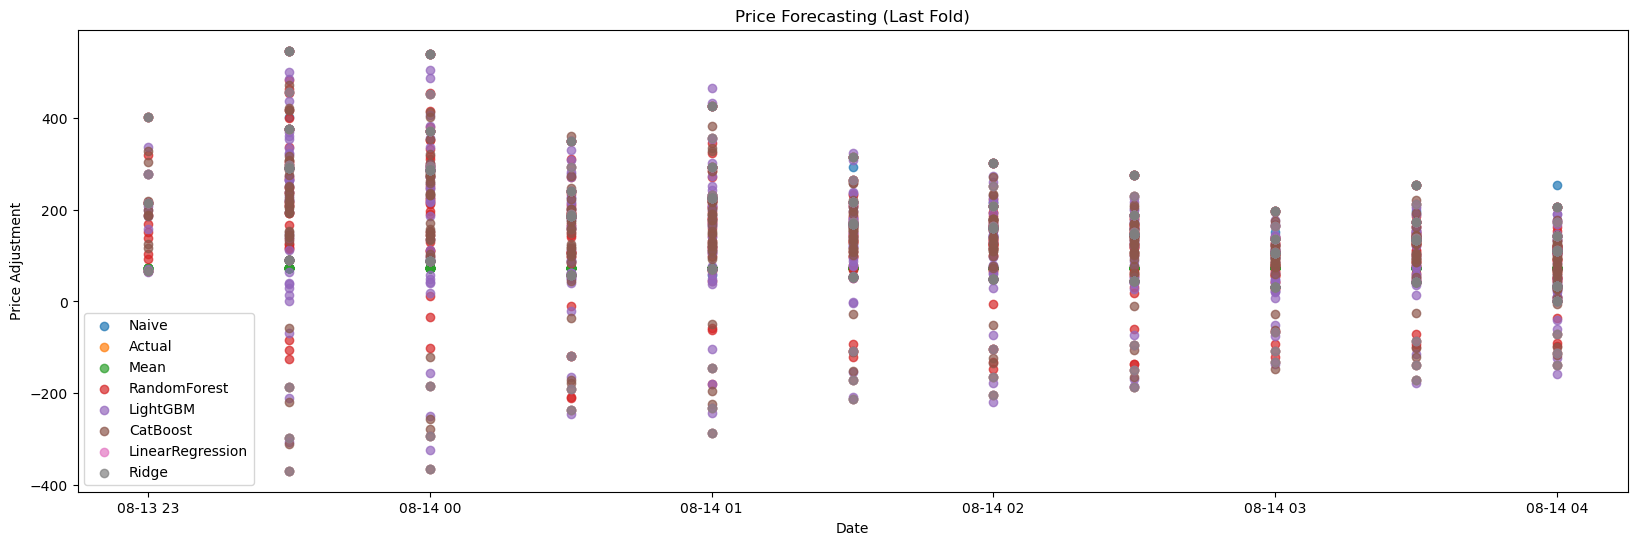

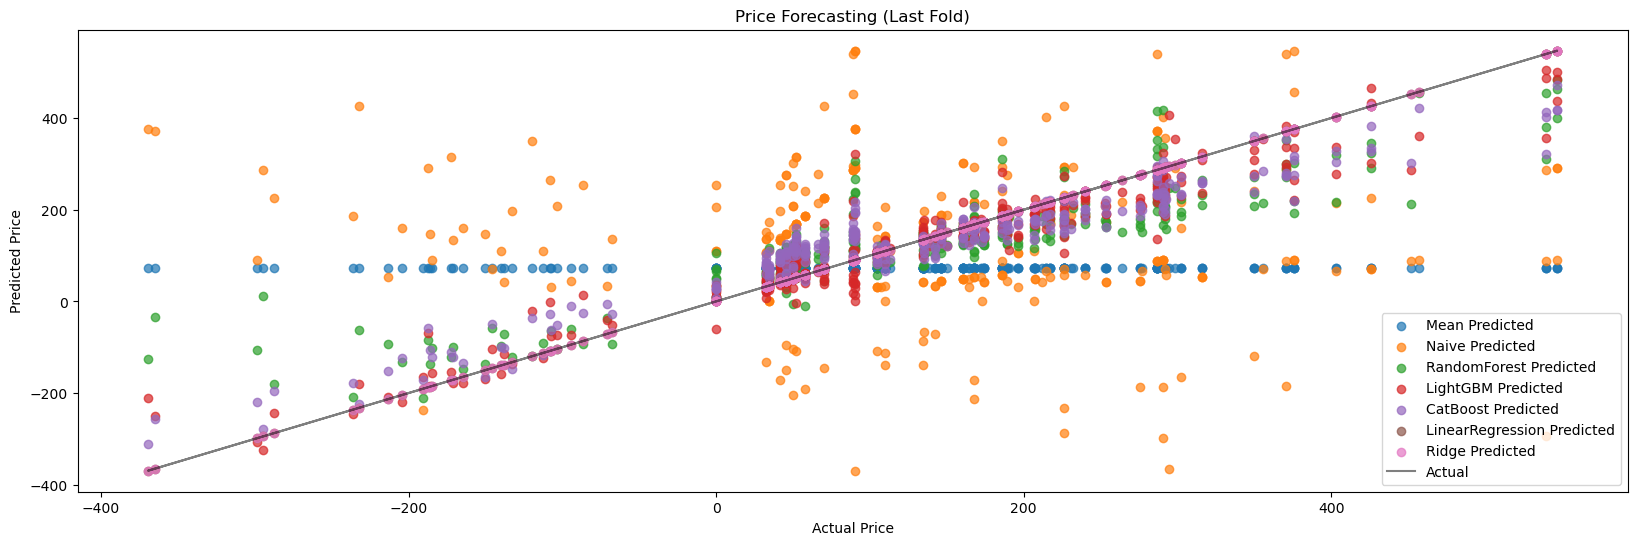

In [29]:

# -----------------------
# 5. Final Plot (last fold only)
# -----------------------
plt.figure(figsize=(20,6))
for model in ["Naive","Actual", "Mean",  "RandomForest", "LightGBM", "CatBoost", "LinearRegression", "Ridge"]:
    y_pred_last_fold = pd.Series(y_pred0[model], index=y_pred0["Actual"].index)
    plt.scatter(y_pred_last_fold.index,y_pred_last_fold, label=model,alpha=0.7)

plt.legend()
plt.title("Price Forecasting (Last Fold)")
plt.xlabel("Date")
plt.ylabel("Price Adjustment")
plt.savefig("../outputs/plots/price_forecasting_last_fold_original_1.png", bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,6))
for model in ["Mean", "Naive", "RandomForest", "LightGBM", "CatBoost", "LinearRegression", "Ridge"]:
    y_pred_last_fold = y_pred0[model]
    plt.scatter(y_pred0["Actual"].values, y_pred_last_fold, label=f"{model} Predicted", alpha=0.7)
plt.plot(y_pred0["Actual"].values, y_pred0["Actual"].values, color='black', label="Actual", alpha=0.5)
plt.xlabel("Actual Price")  
plt.ylabel("Predicted Price")
plt.legend()
plt.title("Price Forecasting (Last Fold)")
plt.savefig("../outputs/plots/price_forecasting_last_fold_original_2.png", bbox_inches='tight')
plt.show()



[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 70.189033
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

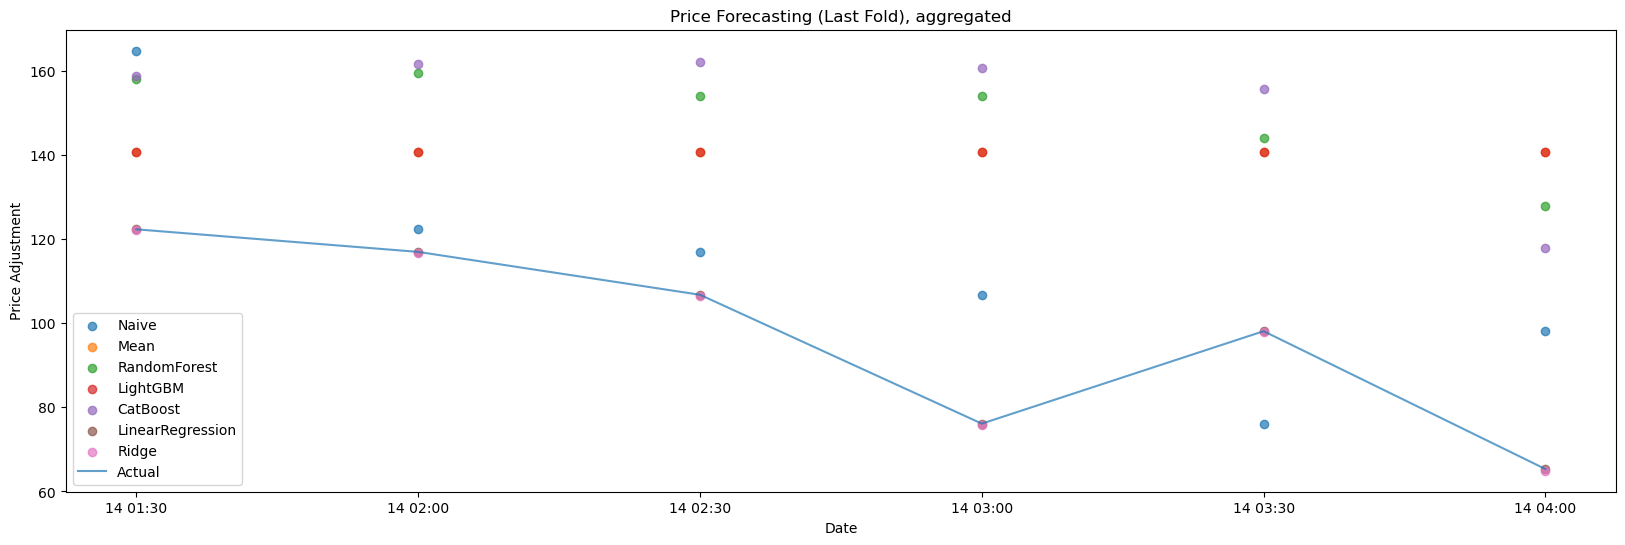

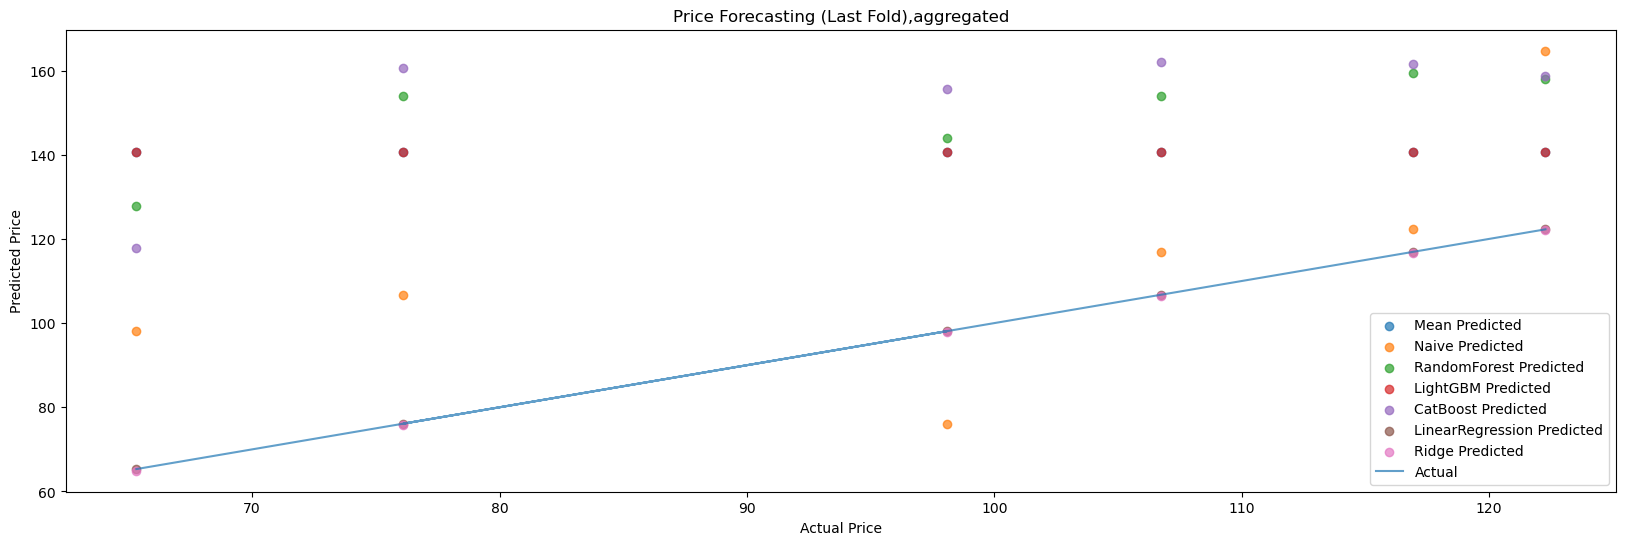

In [30]:
# For aggregated dataset
y_pred_agg = run_cross_validation(X_agg, y_agg, results_agg)

plt.figure(figsize=(20,6))
for model in ["Naive", "Mean",  "RandomForest", "LightGBM", "CatBoost", "LinearRegression", "Ridge"]:
    y_pred_last_fold = pd.Series(y_pred_agg[model], index=y_pred_agg["Actual"].index)
    plt.scatter(y_pred_last_fold.index,y_pred_last_fold, label=model,alpha=0.7)
plt.plot(y_pred_agg["Actual"].index, y_pred_agg["Actual"], label="Actual", alpha=0.7)
plt.legend()
plt.title("Price Forecasting (Last Fold), aggregated")
plt.xlabel("Date")
plt.ylabel("Price Adjustment")
plt.savefig("../outputs/plots/price_forecasting_last_fold_aggregated_1.png", bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,6))
for model in ["Mean", "Naive", "RandomForest", "LightGBM", "CatBoost", "LinearRegression", "Ridge"]:
    y_pred_last_fold = y_pred_agg[model]
    plt.scatter(y_pred_agg["Actual"].values, y_pred_last_fold, label=f"{model} Predicted", alpha=0.7)
plt.plot(y_pred_agg["Actual"].values, y_pred_agg["Actual"], label="Actual", alpha=0.7)
plt.xlabel("Actual Price")  
plt.ylabel("Predicted Price")
plt.legend()
plt.title("Price Forecasting (Last Fold),aggregated")
plt.savefig("../outputs/plots/price_forecasting_last_fold_aggregated_2.png", bbox_inches='tight')
plt.show()


In [31]:

# -----------------------
# 4. Collect Results
# -----------------------
results0_df = pd.DataFrame(results0)
print(results0_df)

# Aggregate by model type
results0_df["BaseModel"] = results0_df["Model"].str.split(r" \(").str[0]
summary0 = results0_df.groupby("BaseModel").agg({"MAE": "mean", "RMSE": "mean"}).reset_index()
print("\nAverage CV Performance:")
print(summary0)




                         Model           MAE          RMSE
0               Naive (Fold 1)  2.174234e+01  3.534134e+01
1               Mean ( Fold 1)  2.555694e+01  3.497986e+01
2   LinearRegression ( Fold 1)  3.958029e-13  8.819921e-13
3              Ridge ( Fold 1)  1.720531e-03  3.682771e-03
4       RandomForest ( Fold 1)  1.048614e+01  1.559311e+01
5           LightGBM ( Fold 1)  9.661106e+00  1.425486e+01
6           CatBoost ( Fold 1)  1.480576e+01  1.960647e+01
7               Naive (Fold 2)  7.724520e+01  1.337039e+02
8               Mean ( Fold 2)  6.512882e+01  1.034732e+02
9   LinearRegression ( Fold 2)  1.737441e-13  2.590792e-13
10             Ridge ( Fold 2)  7.699408e-04  1.223761e-03
11      RandomForest ( Fold 2)  3.936021e+01  8.081026e+01
12          LightGBM ( Fold 2)  3.956210e+01  8.943299e+01
13          CatBoost ( Fold 2)  4.030990e+01  8.218708e+01
14              Naive (Fold 3)  1.155647e+02  1.636269e+02
15              Mean ( Fold 3)  9.805156e+01  1.343398e+

In [32]:

# -----------------------
# 4. Collect Results
# -----------------------
results_agg_df = pd.DataFrame(results_agg)
print(results_agg_df)

# Aggregate by model type
results_agg_df["BaseModel"] = results_agg_df["Model"].str.split(r" \(").str[0]
summary_agg = results_agg_df.groupby("BaseModel").agg({"MAE": "mean", "RMSE": "mean"}).reset_index()
print("\nAverage CV Performance:")
print(summary_agg)




                         Model           MAE          RMSE
0               Naive (Fold 1)  6.950366e+01  7.427857e+01
1               Mean ( Fold 1)  5.434859e+01  6.362990e+01
2   LinearRegression ( Fold 1)  7.974133e+01  8.478167e+01
3              Ridge ( Fold 1)  7.966541e+01  8.471099e+01
4       RandomForest ( Fold 1)  5.622601e+01  6.541895e+01
5           LightGBM ( Fold 1)  5.434859e+01  6.362990e+01
6           CatBoost ( Fold 1)  5.561536e+01  6.511530e+01
7               Naive (Fold 2)  1.159508e+02  1.986710e+02
8               Mean ( Fold 2)  1.518386e+02  2.219161e+02
9   LinearRegression ( Fold 2)  3.171357e+01  5.981670e+01
10             Ridge ( Fold 2)  3.526556e+01  6.472965e+01
11      RandomForest ( Fold 2)  1.513277e+02  2.268278e+02
12          LightGBM ( Fold 2)  1.518386e+02  2.219161e+02
13          CatBoost ( Fold 2)  1.508462e+02  2.234381e+02
14              Naive (Fold 3)  8.713699e+01  1.213478e+02
15              Mean ( Fold 3)  2.231659e+02  2.276454e+

In [33]:
summary0

,BaseModel,MAE,RMSE
0,CatBoost,8.178540e+01,1.210352e+02
1,LightGBM,7.592439e+01,1.189148e+02
2,LinearRegression,3.685698e-13,5.656239e-13
3,Mean,1.265102e+02,1.702363e+02
4,Naive,1.364376e+02,2.005395e+02
5,RandomForest,7.809985e+01,1.168906e+02
6,Ridge,6.189980e-04,1.150854e-03


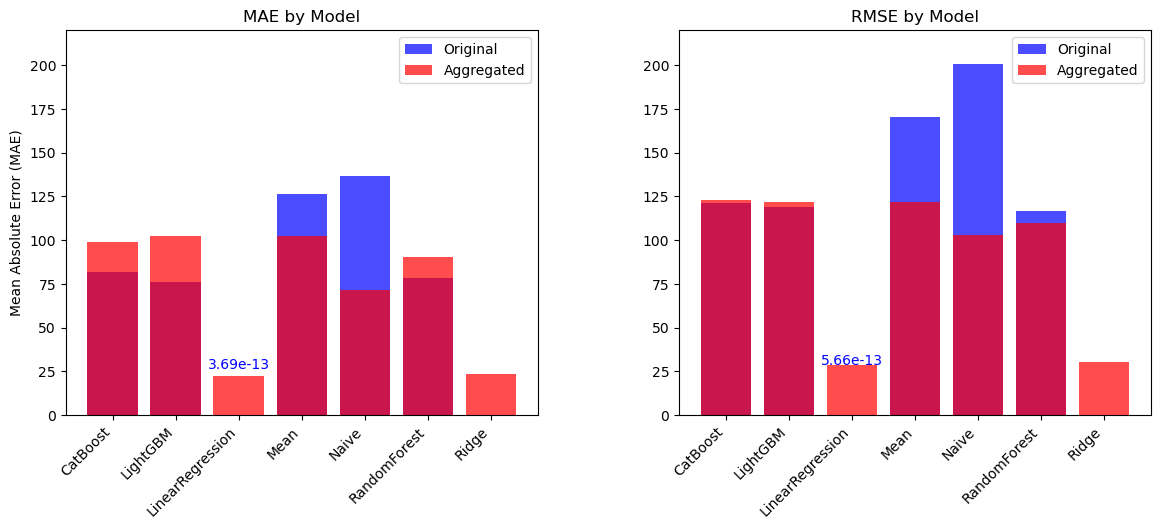

In [34]:
#clean the plots
plt.clf()
plt.close('all')
# plot MAE and RMSE in two seperate plots
fig,ax = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.3)


value_1 = summary0[summary0['BaseModel']=="LinearRegression"]["MAE"].values[0]
plt.subplot(1, 2, 1)
plt.bar(summary0["BaseModel"], summary0["MAE"], color="blue", alpha=0.7,label="Original")
plt.bar(summary_agg["BaseModel"], summary_agg["MAE"], color="red", alpha=0.7,label="Aggregated")
plt.text(2, 25, f"{value_1:.2e}", ha='center', va='bottom',color="blue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by Model")  
plt.ylim(top=220)
plt.legend()

value_2 = summary0[summary0['BaseModel']=="LinearRegression"]["RMSE"].values[0]
plt.subplot(1, 2, 2)
plt.bar(summary0["BaseModel"], summary0["RMSE"], color="blue", alpha=0.7,label="Original")
plt.bar(summary_agg["BaseModel"], summary_agg["RMSE"], color="red", alpha=0.7,label="Aggregated")
plt.text(2, 27, f"{value_2:.2e}", ha='center', va='bottom',color="blue")
plt.xticks(rotation=45, ha="right")
plt.title("RMSE by Model")  
plt.ylim(top=220)
plt.legend()



plt.savefig("../outputs/plots/prediction_errors_average.png", bbox_inches='tight')

plt.show()  



## Conclustion:
For aggregated data, the base models like Naive and Mean predictions are comparable with ML models. However, ML models can predict much better with DUID information kept in dataset. As the ML models perform a lot better than base models. Linear regression performs the best of all.
Modeling does not improve with aggregation, as it used a lot of information that predicts the signal.
So we keep the DUID data and proceed modeling per-DUID.
